## **Modelo de batería de litio vs ANSYS**

* Estudiante 1: Ricardo Torres
* Estudiante 2: Eduardo Moya
* Ayudante: Rafael de la Sotta

El siquiente código corresponde a un modelo de pack de baterías de litio. \\
Adicionalmente este código tiene una evaluación del modelo en comparación de simulaciones del programa ANSYS. \\

Dado un dataset de simulaciones de ansys (53 celdas), para cada simulación se realiza una con el modelo paramétrico, luego se realiza un calculo general del error.


In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import os
import re
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
path_data_ansys = "DATA_ANSYS/"

In [5]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## 1 .- INDIVIDUOS

En esta sección se plantea el individuo base obtenido por Rafael de la Sotta.

In [6]:
global ind
ind = [ lambda Re, S: S**(-0.6) + 5.0*Re**(-0.23), \
        lambda Re, S: 20.0*(S*Re**0.2)**(-1.1), \
        lambda Re, Pr, S: 0.5*S**(-0.2)*Re**0.63*Pr]

Las siguientes clases se utilizan para realizar la optimización

In [7]:
# Clase para las funciones ind
class IndFunction:
    def __init__(self, constants):
        self.constants = constants

    def __call__(self, *args):
        raise NotImplementedError("Subclasses must implement __call__ method")

# Clases concretas para las funciones ind específicas
class Ind1(IndFunction):
    def __call__(self, Re, S):
        c1, c2, c3 = self.constants
        return S**(c1) + c2*Re**(c3)

class Ind2(IndFunction):
    def __call__(self, Re, S):
        c4, c5, c6 = self.constants
        return c4*(S*Re**c5)**(c6)

class Ind3(IndFunction):
    def __call__(self, Re, Pr, S):
        c7, c8, c9 = self.constants
        return c7*S**(c8)*Re**c9*Pr

## 2 .- MODELO

Modelo desarrollado por Rafael de la Sotta

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

###############      Funciones de interpolación      #############

def interpolate1d(x2predict, xtrain, ytrain):
    f = interpolate.interp1d(xtrain, ytrain, fill_value='extrapolate')
    return f(x2predict)

def q_conductividad(_t):
    _t += 273.15
    _datos = np.array([22.3, 26.3, 30, 33.8, 37.3]) * 1e-3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _k = interpolate1d(_t, _temp, _datos)
    np.place(_k, _k < 0, 0.0001)
    np.place(_k, np.isnan(_k), 0.0001)
    return _k

def q_reynolds(_v, _t, _D, _d):
    _visc = q_viscosidad(_t)
    _re = _d * _v * _D / _visc
    return _re

def q_viscosidad(_t):
    _t += 273.15
    _datos = np.array([159.6, 184.6, 208.2, 230.1, 250.7]) * 1e-7
    _temp = np.array([250, 300, 350, 400, 450])
    _visc = interpolate1d(_t, _temp, _datos)
    np.place(_visc, np.isnan(_visc), 0)
    return _visc

def q_densidad(_t):
    _datos = np.array([1.293, 1.205, 1.127])
    _temp = np.array([0, 20, 40]) * 1.
    _d = interpolate1d(_t, _temp, _datos)
    np.place(_d, np.isnan(_d), 1.0)
    return _d

def q_cp(_t):
    _t += 273.15
    _datos = np.array([1.006, 1.007, 1.009, 1.014, 1.021]) * 1e3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _cp = interpolate1d(_t, _temp, _datos)
    np.place(_cp, np.isnan(_cp), 1.0)
    return _cp

###############       Ponderadores        ################

def f_v(S,D):
  return ((D--22.078451156303014)**0.13854518356399528*((S+-0.05273979112677948))**-0.4042472525258598)

def f_tf(I,Fo):
    output = (((34.861727563296036/Fo))**0.060547458674721236/(0.9882458698876305)**I)
    return output

def f_p(S,Fo):
  return (((34.861727563296036/S))**0.060547458674721236/(0.9882458698876305)**Fo)

def f_heat(S):
  return 0.713711013825012*(S**2)-2.37719740945025*S+3.82926914078176

class Model:
    def __init__(self, current=5, cellDiamater=26, separation=1, initFlow=100, \
                 initTemperature=26, col_fluido=2, col_celda=1, n_fluido=3, n_celda=0,\
                 nmax=50):
        """
		"""
        self.current = 1.0 * current                   # Corriente                   [A]
        self.cellDiameter = 1.0*cellDiamater           # Diametro Celda              [mm]
        self.separation = 1.0*separation               # Separacion                  [adimensional]
        self.initFlow = 1.0*initFlow                   # Flujo de entrada del fluido [CFM]
        self.initTemperature  = 1.0*initTemperature    # Temperatura incial          [Degree C]
        self.col_fluido = col_fluido
        self.col_celda = col_celda
        self.n_fluido = n_fluido
        self.n_celda = n_celda
        self.R = 32 * 1e-3      # Resistencia interna [Ohm]
        self.largo = 65 * 1e-3  # Largo celdas        [m]
        self.e = 15 * 1e-3      # espacio pared-celda [m]
        self.referencePressure = 0    # presion de referencia [Pa]
        self.errmax = 1e-3      # error corte
        self.nmax = nmax        # Iteraciones fluodinamicas

        self.sp = dict()        # Variables calculadas
        self.vars_vec = dict()
        self.err_vec = dict()

        self.cellDiameter_m = None
        self.initFlow_m3_sg = None
        self.individual = dict()


    def start(self):
        # ------------------------- Inputs Conversion --------------------------------
        self.cellDiameter_m = self.cellDiameter / 1000  # Diametro Celda              [mm]->[m]
        self.initFlow_m3_sg = self.initFlow * 0.00047   # Flujo de entrada del fluido [CFM]->[m3/s]

        # --------------------- Fixed parameters ------------------------------
        self.sp['piQuarter'] = np.pi / 4
        self.sp['doubleE'] = 2 * self.e
        self.sp['maxValue'] = np.finfo(np.float_).max

        # Medidas importantes
        self.sp['height'] = self.sp['doubleE'] + self.cellDiameter_m*(self.n_fluido + self.separation*self.n_celda)         # Altura del pack
        self.sp['sPlusOne'] = self.separation + 1
        self.sp['sTerm'] = self.separation / self.sp['sPlusOne']

        # Áreas
        self.sp['A_vol_in'] = self.separation * self.cellDiameter_m * self.largo     # Area de entrada al volumen de control
        self.sp['A_cell_sec'] = self.cellDiameter_m * self.largo                           # Area de sombra de una celda
        self.sp['A_battery_in'] = self.sp['height'] * self.largo                                # Area de entrada pack
        self.sp['A_cell_manto'] = np.pi * self.cellDiameter_m * self.largo                   # Area de la celda (manto)

        # /********************** Condiciones de borde *****************************************/
        v_in = self.initFlow_m3_sg/self.sp['A_battery_in']

        self.sp['initVelocity'] = f_v(self.separation,self.cellDiameter) * v_in
        self.sp['initTemperature'] = f_tf(self.current,self.initFlow) * self.initTemperature
        self.sp['lastPressure'] = f_p(self.separation,self.initFlow) + self.referencePressure

        # Cálculos de energía
        self.sp['qdot_cell'] = (self.current**2) * self.R                                             # Flujo de Calor total celda
        self.sp['qdot_vol'] = f_heat(self.separation) * self.sp['qdot_cell']                          # Flujo de Calor total volumen de control
        self.sp['heatPerArea'] = self.sp['qdot_cell'] / self.sp['A_cell_manto']
        self.sp['m_punto'] = self.sp['A_vol_in'] * self.sp['initVelocity'] * q_densidad(self.sp['initTemperature']) # Flujo masico [kg/s]
        self.sp['fluidTempTerm'] = self.sp['qdot_vol'] / self.sp['m_punto']

        # /********************** Initialization *****************************************/
        self.vars_vec['tf'] = self.sp['initTemperature'] * np.ones(self.col_fluido)      # [Degree C]
        self.vars_vec['pf'] = self.sp['lastPressure'] * np.ones(self.col_fluido)          # [Pa]
        self.vars_vec['vf'] = self.sp['initVelocity'] * np.ones(self.col_fluido)       # [m/s]
        self.vars_vec['vmf'] = self.sp['initVelocity'] * self.sp['sTerm'] * np.ones(self.col_fluido)      # [m/s]
        self.vars_vec['df'] = q_densidad(self.sp['initTemperature'])  * np.ones(self.col_fluido)                       # [kg/m3]
        self.vars_vec['tc'] = self.sp['initTemperature'] * np.ones(self.col_celda)       # [Degree C]
        self.vars_vec['ff'] = 0.0 * np.ones(self.col_fluido)                       # [N]
        self.vars_vec['rem'] = 1.0 * np.ones(self.col_celda)                       # [adimensional]
        self.vars_vec['prandtl'] = 0.0 * np.ones(self.col_celda)                       # [adimensional]

        self.vars_vec['cdrag'] = 0.0 * np.ones(self.col_celda)                      # [adimensional]
        self.vars_vec['frctionFactor'] = 0.0 * np.ones(self.col_celda)                        # [adimensional]
        self.vars_vec['nusselt'] = 0.0 * np.ones(self.col_celda)                        # [adimensional]

        self.vars_vec['fluidK'] = q_conductividad(self.vars_vec['tf'][0]) * np.ones(self.col_celda)  # [W/m k]

        # /********************** Errores en columnas ************************************/
        self.err_vec['cellTempError'] = self.sp['maxValue'] * np.ones(self.col_celda)
        self.err_vec['TFError'] = self.sp['maxValue'] * np.ones(self.col_fluido)
        self.err_vec['TFError'][0] = 0.0
        self.err_vec['velocityError'] = self.sp['maxValue'] * np.ones(self.col_fluido)
        self.err_vec['pressureError'] = self.sp['maxValue'] * np.ones(self.col_celda)

    def evolve(self):
        for _ in range(self.nmax):
            for i in range(self.col_celda):
                actualVF = self.vars_vec['vf'][i]
                actualVMF = self.sp['sTerm'] * actualVF
                self.vars_vec['vmf'][i] = actualVMF
                actualTF = self.vars_vec['tf'][i]
                nextTF = self.vars_vec['tf'][i]
                actualTMF = (actualTF+nextTF)/2
                actualDF = self.vars_vec['df'][i]
                i2 = i+1
                self.vars_vec['rem'][i] = q_reynolds(actualVMF, actualTMF, self.cellDiameter_m, actualDF)
                self.vars_vec['prandtl'][i] = q_viscosidad(actualTMF) * q_cp(actualTMF) / q_conductividad(actualTMF)
                actualRem = self.vars_vec['rem'][i]
                actualprandtl = self.vars_vec['prandtl'][i]

                # ***************************************** Calculo de la presion **************************************
                frictionFactor = self.individual['computeFrictionFactor'](actualRem, self.separation)
                self.vars_vec['frctionFactor'][i] = frictionFactor
                nextPF = self.vars_vec['pf'][i2]
                actualPF = nextPF + 0.5 * frictionFactor * actualDF * (actualVMF ** 2)
                self._setValue(self.vars_vec['pf'], i, self.err_vec['pressureError'], actualPF)

                # ***************************************** Calculo de la velocidad ************************************
                cdrag = self.individual['computeDragCoefficient'](actualRem, self.separation)
                self.vars_vec['cdrag'][i] = cdrag
                actualVFSquared = (actualVF ** 2)
                actualVMFSquared = (actualVMF ** 2)
                actualFF_cell = 0.5 * self.sp['A_cell_sec']  * actualDF * actualVMFSquared * cdrag
                actualFF_vol = 2*actualFF_cell
                self.vars_vec['ff'][i] = actualFF_vol
                nextVF = ((self.sp['A_vol_in'] * (actualPF - nextPF) - actualFF_vol) / self.sp['m_punto']) + actualVF
                nextVFSquared = (nextVF ** 2)
                self._setValue(self.vars_vec['vf'], i2, self.err_vec['velocityError'], nextVF)

                # ********************************** Calculo de la temperatura fluido **********************************
                nextTF = actualTF + (self.sp['fluidTempTerm'] - 0.5 * (nextVFSquared - actualVFSquared)) / q_cp(actualTF)
                self._setValue(self.vars_vec['tf'], i2, self.err_vec['TFError'], nextTF)

                # ***************************************** Calculo de la densidad *************************************
                self.vars_vec['df'][i2] = q_densidad(nextTF)

                # ********************************** Calculo de temperatura de celda ************************************
                actualTMF = (actualTF + nextTF) / 2
                nu = self.individual['computeNusseltNumber'](actualRem, actualprandtl, self.separation)
                self.vars_vec['nusselt'][i] = nu
                iniFluidK = q_conductividad(actualTF)
                self.vars_vec['fluidK'][i] = iniFluidK
                h = nu * iniFluidK / self.cellDiameter_m # [W m^-2 K^-1]
                self._setValue(self.vars_vec['tc'], i, self.err_vec['cellTempError'], self.sp['heatPerArea'] / h + actualTMF)

            # ********************************** If convergence, stop iterating ************************************
            flag1 = self.err_vec['cellTempError'].max() <= self.errmax
            flag2 = self.err_vec['TFError'].max() <= self.errmax
            flag3 = self.err_vec['pressureError'].max() <= self.errmax
            flag4 = self.err_vec['velocityError'].max() <= self.errmax
            flag12 = np.logical_and(flag1, flag2)
            flag34 = np.logical_and(flag3, flag4)
            if np.logical_and(flag12, flag34):
                break

        # ********************************** Guardar ************************************
        results_dict = {}
        results_dict['cdrag'] = self.vars_vec['cdrag']
        results_dict['frctionFactor'] = self.vars_vec['frctionFactor']
        results_dict['nusselt'] = self.vars_vec['nusselt']
        results_dict['vf'] = self.vars_vec['vf']
        results_dict['pf'] = self.vars_vec['pf']
        results_dict['tc'] = self.vars_vec['tc']
        results_dict['tf'] = self.vars_vec['tf']
        return results_dict

    def reset(self):
        self.__init__()

    def _setValue(self, vector, i, errorArray, value):
        errorArray[i] = vector[i]
        vector[i] = value
        errorArray[i] = np.abs((errorArray[i] - value) / value)

    def load_individual(self, cdrag_tree, ffriction_tree, nnusselt_tree):
        '''
        :param cdrag_tree:     inputs(5) (reynolds, separation, index, normalizedArea, normalizedDensity)
        :param ffriction_tree: inputs(5) (reynolds, separation, index, normalizedVelocity, normalizedDensity)
        :param nnusselt_tree:  inputs(4) (reynolds, prandtl, separation, index)
        '''
        self.individual['computeDragCoefficient'] = cdrag_tree
        self.individual['computeFrictionFactor']  = ffriction_tree
        self.individual['computeNusseltNumber']   = nnusselt_tree


def pow2(x):
    return x**2

## 3 .- FUNCIONES

In [9]:
def get_ansys_mf_all():
  df_ansys_all = pd.DataFrame()
  df_mf_all = pd.DataFrame()
  for ncells in [25,53,74,102]:
    print('obteniendo datos de somulación: ' + str(ncells) + ' celdas')
    df_ansys, df_mf = get_ansys_mf(ncells)
    df_ansys_all = df_ansys_all.append(df_ansys, ignore_index=True)
    df_mf_all = df_mf_all.append(df_mf, ignore_index=True)
  return df_ansys_all, df_mf_all

In [17]:
def get_ansys_mf(n_celdas, df_ansys=None,nmax=10):  # ind como entrada
  col_fluido=int((n_celdas+3)/7)
  col_celda=int(col_fluido-1)
  # ANSYS
  if df_ansys is None:
    print('Calculando ansys')
    df_ansys = get_data_simple(get_dataFrame(path_data_ansys + 'entradas_1_'+str(n_celdas)+'_celdas.csv'))
  # MF
  df_mf = df_ansys[['Current'	,'K','Flujo','t_viento','Diametro']]
  for i in range(col_fluido):
    num_string = str(i+1)
    if len(num_string)<2:
      num_string = '0' + num_string
    df_mf['V' + num_string] = None
    df_mf['P' + num_string] = None
    df_mf['TF' + num_string] = None
    if i != (col_fluido-1):
      df_mf['TC' + num_string] = None

  for index, row in df_mf.iterrows():
    mdl = Model(current=row['Current'], cellDiamater=row['Diametro'], separation=row['K'], initFlow=row['Flujo'], initTemperature=row['t_viento'], col_fluido=col_fluido, col_celda=col_celda, n_fluido=4, n_celda=3, nmax=10)
    mdl.load_individual(*ind)
    mdl.start()
    results_dict = mdl.evolve()
    V_array = results_dict['vf']
    P_array = results_dict['pf']
    T_array = results_dict['tf']
    TC_array = results_dict['tc']
    for i in range(col_fluido):
      num_string = str(i+1)
      if len(num_string)<2:
        num_string = '0' + num_string
      df_mf.at[index,'V' + num_string] = V_array[i]
      df_mf.at[index,'P' + num_string] = P_array[i]
      df_mf.at[index,'TF' + num_string] = T_array[i]
      if i != (col_fluido-1):
        df_mf.at[index,'TC' + num_string] = TC_array[i]
  return df_ansys, df_mf

In [11]:
def get_mf(n_celdas):
  col_fluido=int((n_celdas+3)/7)
  col_celda=int(col_fluido-1)
  # ANSYS
  df_ansys = get_data_simple(get_dataFrame(path_data_ansys + 'entradas_1_'+str(n_celdas)+'_celdas.csv'))
  # MF
  df_mf = df_ansys[['Current'	,'K','Flujo','t_viento','Diametro']]
  for i in range(col_fluido):
    num_string = str(i+1)
    if len(num_string)<2:
      num_string = '0' + num_string
    df_mf['V' + num_string] = None
    df_mf['P' + num_string] = None
    df_mf['TF' + num_string] = None
    if i != (col_fluido-1):
      df_mf['TC' + num_string] = None
      df_mf['cdrag' + num_string] = None
      df_mf['frctionFactor' + num_string] = None
      df_mf['nusselt' + num_string] = None

  for index, row in df_mf.iterrows():
    mdl = Model(current=row['Current'], cellDiamater=row['Diametro'], separation=row['K'], initFlow=row['Flujo'], initTemperature=row['t_viento'], col_fluido=col_fluido, col_celda=col_celda, n_fluido=4, n_celda=3, nmax=10)
    mdl.load_individual(*ind)
    mdl.start()
    results_dict = mdl.evolve()
    V_array = results_dict['vf']
    P_array = results_dict['pf']
    T_array = results_dict['tf']
    TC_array = results_dict['tc']
    CD_array = results_dict['cdrag']
    FF_array = results_dict['frctionFactor']
    NU_array = results_dict['nusselt']
    for i in range(col_fluido):
      num_string = str(i+1)
      if len(num_string)<2:
        num_string = '0' + num_string
      df_mf.at[index,'V' + num_string] = V_array[i]
      df_mf.at[index,'P' + num_string] = P_array[i]
      df_mf.at[index,'TF' + num_string] = T_array[i]
      if i != (col_fluido-1):
        df_mf.at[index,'TC' + num_string] = TC_array[i]
        df_mf.at[index,'cdrag' + num_string] = CD_array[i]
        df_mf.at[index,'frctionFactor' + num_string] = FF_array[i]
        df_mf.at[index,'nusselt' + num_string] = NU_array[i]
  return df_mf

In [12]:
def get_dataFrame(namefile):
  data = pd.read_csv(namefile, header=6)
  colCoded = data.columns.tolist()
  nameCode = pd.read_csv(namefile, header=3,nrows=1)
  colName = [[col.replace(d+' - ','') for i,col in enumerate(nameCode) if re.search(d, col)] for d in colCoded]
  colName = [temp[0] if temp else 'Name' for temp in colName]
  colName = [temp if (' ' not in temp) else temp[:temp.index(' ')] for temp in colName]
  data.rename(columns=dict(zip(colCoded, colName)), inplace=True)
  data.dropna(inplace=True)
  data.drop_duplicates(inplace=True)
  data = data[data['Flujo']>10]
  data = data[data['Current']>0]
  data.reset_index(inplace=True)
  return data

def get_data_simple(df):
  df_output = df[['celda1.ny','celda2.ny','celda1.nx','celda2.nx','Current', 'K', 'Flujo', 't_viento', 'Diametro']]
  for string in ['V','P','TF','TC']:
    if 'T' in string:
      df_aux = df.filter(regex=(string + "+\d")) - 273.15
    else:
      df_aux = df.filter(regex=(string + "+\d"))
    df_output = pd.concat([df_output,df_aux], axis=1)
  df_output = df_output[ df_output['Flujo'] > 10]
  df_output.reset_index(drop=True,inplace=True)
  return df_output

In [13]:
def interpolate1d(x2predict, xtrain, ytrain):
    f = interpolate.interp1d(xtrain, ytrain, fill_value='extrapolate')
    return f(x2predict)
    #return np.array(np.interp(x2predict, xtrain, ytrain))

def q_conductividad(_t):
    _t += 273.15
    _datos = np.array([22.3, 26.3, 30, 33.8, 37.3]) * 1e-3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _k = interpolate1d(_t, _temp, _datos)
    np.place(_k, _k < 0, 0.0001)
    np.place(_k, np.isnan(_k), 0.0001)
    return _k

def q_reynolds(_v, _t, _D, _d):
    _visc = q_viscosidad(_t)
    _re = _d * _v * _D / _visc
    return _re

def q_viscosidad(_t):
    _t += 273.15
    _datos = np.array([159.6, 184.6, 208.2, 230.1, 250.7]) * 1e-7
    _temp = np.array([250, 300, 350, 400, 450])
    _visc = interpolate1d(_t, _temp, _datos)
    np.place(_visc, np.isnan(_visc), 0)
    return _visc

def q_paramdrag(_s):
    _b1 = np.array([0.039, 0.028, 0.027, 0.028, 0.005])
    _b2 = np.array([3.270, 2.416, 2.907, 2.974, 2.063])
    _x = np.array([0.10, 0.25, 0.50, 0.75, 1.00])
    _a1 = interpolate1d(_s, _x, _b1)
    _a2 = interpolate1d(_s, _x, _b2)
    if _s > _x[-1]:
        _a1 = _b1[-1]
        _a2 = _b2[-1]
    if _a1 < 0:
        _a1 = 0
    if _a2 < 0:
        _a2 = 0
    return _a1, _a2

def q_densidad(_t):
    _datos = np.array([1.293, 1.205, 1.127])
    _temp = np.array([0, 20, 40]) * 1.
    _d = interpolate1d(_t, _temp, _datos)
    np.place(_d, np.isnan(_d), 1.0)
    return _d

def q_cp(_t):
    _t += 273.15
    _datos = np.array([1.006, 1.007, 1.009, 1.014, 1.021]) * 1e3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _cp = interpolate1d(_t, _temp, _datos)
    np.place(_cp, np.isnan(_cp), 1.0)
    return _cp

In [14]:
def get_MAE_dict(df_ansys,df_mf, axis=None, std=False):
  dict_error = {}
  for output in ['V','P','TF','TC']:
    m_ansys = df_ansys.filter(regex=(output + "+\d")).values
    m_mf = df_mf.filter(regex=(output + "+\d")).values
    if std:
      dict_error[output] = np.std(np.abs(m_ansys - m_mf).astype(float), axis=axis)
    else:
      dict_error[output] = np.mean(np.abs(m_ansys - m_mf).astype(float), axis=axis)
  return dict_error

In [15]:
def get_MAPE_dict(df_ansys,df_mf, axis=None, std=False ):
  dict_error = {}
  for output in ['V','P','TF','TC']:
    m_ansys = df_ansys.filter(regex=(output + "+\d")).values
    m_mf = df_mf.filter(regex=(output + "+\d")).values
    #dict_error[output] = mean_absolute_percentage_error(m_ansys,m_mf)
    if std:
      dict_error[output] = np.std(np.abs((m_ansys - m_mf) / m_ansys).astype(float), axis=axis) * 100
    else:
      dict_error[output] = np.mean(np.abs((m_ansys - m_mf) / m_ansys).astype(float), axis=axis) * 100
  return dict_error

## 4.- Correr modelo

Datos de simulación en CFD

In [23]:
global df_ansys
df_ansys, _ = get_ansys_mf(74)

Calculando ansys


### NSGA-II

In [92]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.util.termination.default import SingleObjectiveDefaultTermination
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import ElementwiseProblem


#PARAMETROS
GEN = 15
POP = 5
MUT = 0.1
CROSSOVER = 0.8

# Definir las funciones de ind con parámetros y constantes originales
ind_original = [
    lambda Re, S: S**(-0.6) + 5.0*Re**(-0.23),
    lambda Re, S: 20.0*(S*Re**0.2)**(-1.1),
    lambda Re, Pr, S: 0.5*S**(-0.2)*Re**0.63*Pr
]

ind = [Ind1([-0.6, 5.0, -0.23]), Ind2([20.0, 0.2, -1.1]), Ind3([0.5, -0.2, 0.63])]

# Extraer los valores originales de las constantes
initial_params = []
for func in ind_original:
    constants = func.__code__.co_consts
    initial_params.extend([c for c in constants if isinstance(c, (int, float))])

# Función que devuelve los resultados de df_mf para un conjunto dado de parámetros
def get_df_mf(params, n_celdas=74):
    global ind
    # Desempaquetar parámetros
    params_ind_1 = params[:3]
    params_ind_2 = params[3:6]
    params_ind_3 = params[6:]

    # Actualizar las constantes de las funciones ind
    ind[0].constants = params_ind_1
    ind[1].constants = params_ind_2
    ind[2].constants = params_ind_3

    # Llamar a tu función original para obtener df_mf
    _, df_mf = get_ansys_mf(n_celdas, df_ansys)

    return df_mf, ind

# Función objetivo para la optimización
def objective(params, n_celdas=74):
    df_mf, ind = get_df_mf(params, n_celdas)
    errors = get_MAPE_dict(df_ansys, df_mf)
    return list(errors.values())


class CustomProblem(ElementwiseProblem):
    def __init__(self, n_var, xl, xu, ind):
        super().__init__(n_var=n_var, n_obj=4, n_constr=0, xl=xl, xu=xu)
        self.ind = ind  # Añadir ind como atributo de la clase

    def _evaluate(self, x, out, *args, **kwargs):
        # Desempaquetar parámetros
        params_ind_1 = x[:3]
        params_ind_2 = x[3:6]
        params_ind_3 = x[6:]

        # Actualizar las constantes de las funciones ind
        self.ind[0].constants = params_ind_1
        self.ind[1].constants = params_ind_2
        self.ind[2].constants = params_ind_3
        # Llamar a tu función original para obtener df_mf
        _, df_mf = get_ansys_mf(n_celdas, df_ansys)

        # Tu lógica de evaluación aquí
        errors = get_MAPE_dict(df_ansys, df_mf)
        out["F"] = list(errors.values())

        
class MyCallback:
    def __init__(self):
        self.rows_list = []

    def __call__(self, algorithm):
        # Obtener el mejor individuo en la población actual
        best_ind = algorithm.pop.get("F").min(axis=0)

        # Obtener las constantes del mejor individuo
        best_constants = algorithm.pop.get("X")[0]

        # Obtener la generación actual
        generation = algorithm.n_gen

        # Crear un diccionario con los datos de la generación actual
        row_dict = {'Generation': generation}
        for i, value in enumerate(best_ind):
            row_dict[f'Objective_{i+1}'] = value
        for i, constant in enumerate(best_constants):
            row_dict[f'Constant_{i+1}'] = constant

        # Añadir la fila al lista
        self.rows_list.append(row_dict)

        # Imprimir el progreso
        print(f"Generation {generation}: Best Objectives = {best_ind}")



# Crear una instancia de la devolución de llamada
callback = MyCallback()
n_celdas = 74

# Inicializar la población con los valores iniciales
initial_population = np.array([initial_params])

# Configurar el algoritmo evolutivo (NSGA-II) con la devolución de llamada
algorithm = NSGA2(
    pop_size=POP,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=CROSSOVER, eta=3.0),
    mutation=get_mutation("real_pm", prob=MUT ,eta=3.0),
    eliminate_duplicates=True,
    pop_initializer=initial_population  # Establecer la población inicial aquí
)

# Definir límites para cada parámetro (ajusta según tus necesidades)
lower_bound = np.array([c - 0.1 for c in initial_params])
upper_bound = np.array([c + 0.1 for c in initial_params])

# Definir problema de optimización
problem = CustomProblem(n_var=len(initial_params), xl=lower_bound, xu=upper_bound, ind=ind)

# Ejecutar la optimización con la devolución de llamada
result = minimize(problem, algorithm, ('n_gen', GEN), callback=callback, seed=1, verbose=True)

# Obtener los mejores parámetros después de la optimización
best_params_pymoo = result.X[0]

# Obtener df_mf para los mejores parámetros
best_df_mf_pymoo, _ = get_df_mf(best_params_pymoo, n_celdas)

# Obtener los errores finales
final_errors_pymoo = get_MAPE_dict(df_ansys, best_df_mf_pymoo)

# Imprimir los resultados
print("Mejores parámetros (pymoo):", best_params_pymoo)
print("Errores finales (pymoo):", final_errors_pymoo)
# Convertir la lista de filas en un DataFrame
columns = ['Generation'] + [f'Objective_{i+1}' for i in range(4)] + [f'Constant_{i+1}' for i in range(9)]
result_df = pd.DataFrame(callback.rows_list, columns=columns)


# Guardar el DataFrame en un archivo CSV
csv_filename = "optimization_results_2.csv"
result_df.to_csv(csv_filename, index=False)

print(f"Resultados guardados en {csv_filename}")

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |       5 |       2 |            - |            -
Generation 1: Best Objectives = [ 10.43063368 182.07752809   2.12616594  11.31585394]
    2 |      10 |       3 |  0.009157704 |        ideal
Generation 2: Best Objectives = [ 10.43063368 182.07752809   2.12616162  11.31585394]
    3 |      15 |       2 |  1.000000000 |        ideal
Generation 3: Best Objectives = [  8.22757984 172.47827735   2.12571893   8.95258291]
    4 |      20 |       4 |  0.438301848 |        ideal
Generation 4: Best Objectives = [  8.22757984 172.47827735   2.12571893   6.57965138]
    5 |      25 |       5 |  0.048345040 |        ideal
Generation 5: Best Objectives = [  8.22757984 165.00517592   2.12571848   6.30259728]
    6 |      30 |       5 |  0.057823395 |        ideal
Generation 6: Best Objectives = [  8.22757984 164.69829079   2.12571848   5.94909565]
    7 |      35 |       5 |  0.063450791 |        ideal
Generation 7: Best Objectives = [  8

In [19]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.util.termination.default import SingleObjectiveDefaultTermination
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import ElementwiseProblem


#PARAMETROS
GEN = 30
POP = 10
MUT = 0.1
CROSSOVER = 0.8

# Definir las funciones de ind con parámetros y constantes originales
ind_original = [
    lambda Re, S: S**(-0.6) + 5.0*Re**(-0.23),
    lambda Re, S: 20.0*(S*Re**0.2)**(-1.1),
    lambda Re, Pr, S: 0.5*S**(-0.2)*Re**0.63*Pr
]

ind = [Ind1([-0.6, 5.0, -0.23]), Ind2([20.0, 0.2, -1.1]), Ind3([0.5, -0.2, 0.63])]

# Extraer los valores originales de las constantes
initial_params = []
for func in ind_original:
    constants = func.__code__.co_consts
    initial_params.extend([c for c in constants if isinstance(c, (int, float))])

# Función que devuelve los resultados de df_mf para un conjunto dado de parámetros
def get_df_mf(params, n_celdas=102):
    global ind
    # Desempaquetar parámetros
    params_ind_1 = params[:3]
    params_ind_2 = params[3:6]
    params_ind_3 = params[6:]

    # Actualizar las constantes de las funciones ind
    ind[0].constants = params_ind_1
    ind[1].constants = params_ind_2
    ind[2].constants = params_ind_3

    # Llamar a tu función original para obtener df_mf
    _, df_mf = get_ansys_mf(n_celdas, df_ansys)

    return df_mf, ind

# Función objetivo para la optimización
def objective(params, n_celdas=74):
    df_mf, ind = get_df_mf(params, n_celdas)
    errors = get_MAPE_dict(df_ansys, df_mf)
    return list(errors.values())


class CustomProblem(ElementwiseProblem):
    def __init__(self, n_var, xl, xu, ind):
        super().__init__(n_var=n_var, n_obj=4, n_constr=0, xl=xl, xu=xu)
        self.ind = ind  # Añadir ind como atributo de la clase

    def _evaluate(self, x, out, *args, **kwargs):
        # Desempaquetar parámetros
        params_ind_1 = x[:3]
        params_ind_2 = x[3:6]
        params_ind_3 = x[6:]

        # Actualizar las constantes de las funciones ind
        self.ind[0].constants = params_ind_1
        self.ind[1].constants = params_ind_2
        self.ind[2].constants = params_ind_3
        # Llamar a tu función original para obtener df_mf
        _, df_mf = get_ansys_mf(n_celdas, df_ansys)

        # Tu lógica de evaluación aquí
        errors = get_MAPE_dict(df_ansys, df_mf)
        out["F"] = list(errors.values())

        
class MyCallback:
    def __init__(self):
        self.rows_list = []

    def __call__(self, algorithm):
        # Obtener el mejor individuo en la población actual
        best_ind = algorithm.pop.get("F").min(axis=0)

        # Obtener las constantes del mejor individuo
        best_constants = algorithm.pop.get("X")[0]

        # Obtener la generación actual
        generation = algorithm.n_gen

        # Crear un diccionario con los datos de la generación actual
        row_dict = {'Generation': generation}
        for i, value in enumerate(best_ind):
            row_dict[f'Objective_{i+1}'] = value
        for i, constant in enumerate(best_constants):
            row_dict[f'Constant_{i+1}'] = constant

        # Añadir la fila al lista
        self.rows_list.append(row_dict)

        # Imprimir el progreso
        print(f"Generation {generation}: Best Objectives = {best_ind}")



# Crear una instancia de la devolución de llamada
callback = MyCallback()
n_celdas = 74

# Inicializar la población con los valores iniciales
initial_population = np.array([initial_params])

# Configurar el algoritmo evolutivo (NSGA-II) con la devolución de llamada
algorithm = NSGA2(
    pop_size=POP,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=CROSSOVER, eta=3.0),
    mutation=get_mutation("real_pm", prob=MUT ,eta=3.0),
    eliminate_duplicates=True,
    pop_initializer=initial_population  # Establecer la población inicial aquí
)

# Definir límites para cada parámetro (ajusta según tus necesidades)
lower_bound = np.array([c - 0.1 for c in initial_params])
upper_bound = np.array([c + 0.1 for c in initial_params])

# Definir problema de optimización
problem = CustomProblem(n_var=len(initial_params), xl=lower_bound, xu=upper_bound, ind=ind)

# Ejecutar la optimización con la devolución de llamada
result = minimize(problem, algorithm, ('n_gen', GEN), callback=callback, seed=1, verbose=True)

# Obtener los mejores parámetros después de la optimización
best_params_pymoo = result.X[0]

# Obtener df_mf para los mejores parámetros
best_df_mf_pymoo, _ = get_df_mf(best_params_pymoo, n_celdas)

# Obtener los errores finales
final_errors_pymoo = get_MAPE_dict(df_ansys, best_df_mf_pymoo)

# Imprimir los resultados
print("Mejores parámetros (pymoo):", best_params_pymoo)
print("Errores finales (pymoo):", final_errors_pymoo)
# Convertir la lista de filas en un DataFrame
columns = ['Generation'] + [f'Objective_{i+1}' for i in range(4)] + [f'Constant_{i+1}' for i in range(9)]
result_df = pd.DataFrame(callback.rows_list, columns=columns)

# Imprimir los resultados
#print("Resultados en cada generación:")
#print(result_df)

# Guardar el DataFrame en un archivo CSV
csv_filename = "optimization_results.csv"
result_df.to_csv(csv_filename, index=False)

print(f"Resultados guardados en {csv_filename}")


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      10 |       2 |            - |            -
Generation 1: Best Objectives = [ 10.43063368 163.4664343    2.12590485   2.61930816]
    2 |      20 |       3 |  0.011430683 |        ideal
Generation 2: Best Objectives = [ 10.42313278 163.4664343    2.12590485   2.61930816]
    3 |      30 |       2 |  0.688917710 |        ideal
Generation 3: Best Objectives = [  8.96990627 163.4664343    2.12590485   2.61930816]
    4 |      40 |       2 |  0.234649956 |        ideal
Generation 4: Best Objectives = [  8.32317133 163.4664343    2.12590485   2.61930816]
    5 |      50 |       6 |  0.620256872 |        ideal
Generation 5: Best Objectives = [  8.32317133 162.14247253   2.12584488   2.61930816]
    6 |      60 |       9 |  0.221

### NSGA-II Con Frente Pareto

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |       5 |       1 |            - |            -
Generation 1: Best Objectives = [ 13.44248698 192.50816177]
    2 |      10 |       1 |  5.145441322 |        ideal
Generation 2: Best Objectives = [  8.29704566 189.7949164 ]
    3 |      15 |       1 |  0.491821943 |        ideal
Generation 3: Best Objectives = [  7.80522372 189.7949164 ]
    4 |      20 |       3 |  1.000000000 |        ideal
Generation 4: Best Objectives = [  6.79261537 189.7949164 ]
    5 |      25 |       4 |  0.005695753 |        ideal
Generation 5: Best Objectives = [  6.79261537 188.66489327]
    6 |      30 |       5 |  0.028998081 |        nadir
Generation 6: Best Objectives = [  6.7892802  188.66489327]
    7 |      35 |       5 |  0.005178996 |        ideal
Generation 7: Best Objectives = [  6.66539855 188.45136114]
    8 |      40 |       5 |  0.091268994 |        ideal
Generation 8: Best Objectives = [  6.60739596 175.62718097]
    9 |      45 

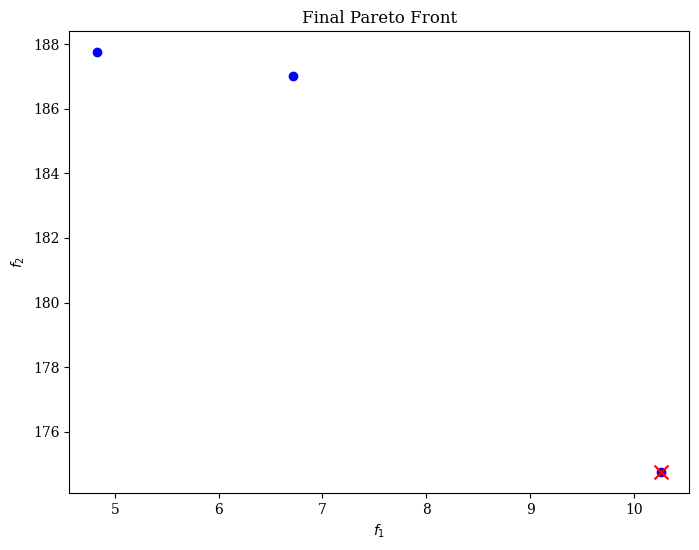

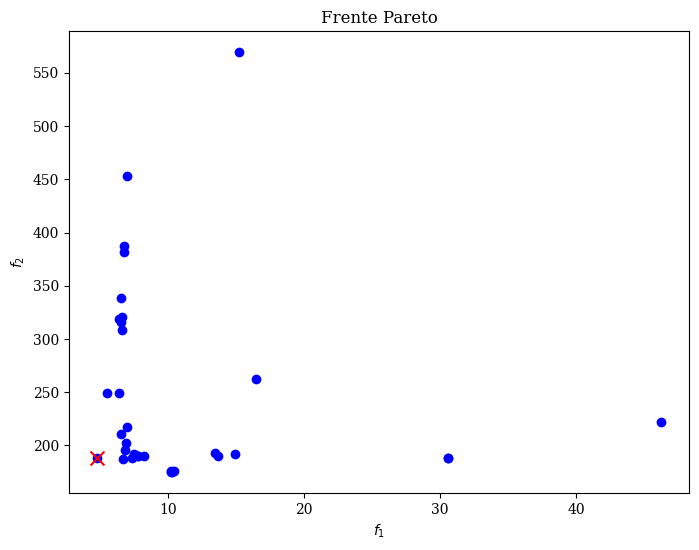

In [41]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.util.termination.default import SingleObjectiveDefaultTermination
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

#PARAMETROS
GEN = 15
POP = 5
MUT = 0.1
CROSSOVER = 0.8

# Definir las funciones de ind con parámetros y constantes originales
ind_original = [
    lambda Re, S: S**(-0.6) + 5.0*Re**(-0.23),
    lambda Re, S: 20.0*(S*Re**0.2)**(-1.1),
    lambda Re, Pr, S: 0.5*S**(-0.2)*Re**0.63*Pr
]

ind = [Ind1([-0.6, 5.0, -0.23]), Ind2([20.0, 0.2, -1.1]), Ind3([0.5, -0.2, 0.63])]

# Extraer los valores originales de las constantes
initial_params = []
for func in ind_original:
    constants = func.__code__.co_consts
    initial_params.extend([c for c in constants if isinstance(c, (int, float))])

# Función que devuelve los resultados de df_mf para un conjunto dado de parámetros
def get_df_mf(params, n_celdas=102):
    global ind
    # Desempaquetar parámetros
    params_ind_1 = params[:3]
    params_ind_2 = params[3:6]
    params_ind_3 = params[6:]

    # Actualizar las constantes de las funciones ind
    ind[0].constants = params_ind_1
    ind[1].constants = params_ind_2
    ind[2].constants = params_ind_3

    # Llamar a tu función original para obtener df_mf
    _, df_mf = get_ansys_mf(n_celdas, df_ansys)

    return df_mf, ind

# Función objetivo para la optimización
# Función objetivo para la optimización con 2 objetivos
def objective(params, n_celdas=74):
    df_mf, ind = get_df_mf(params, n_celdas)
    errors = get_MAPE_dict(df_ansys, df_mf)
    
    # Definir los objetivos (minimizar el error de TF + TC y el error de V + P)
    obj1 = errors['TF'] + errors['TC']
    obj2 = errors['V'] + errors['P']
    
    return [obj1, obj2]


class CustomProblem(ElementwiseProblem):
    def __init__(self, n_var, xl, xu, ind):
        super().__init__(n_var=n_var, n_obj=2, n_constr=0, xl=xl, xu=xu)
        self.ind = ind  # Añadir ind como atributo de la clase

    def _evaluate(self, x, out, *args, **kwargs):
        # Desempaquetar parámetros
        params_ind_1 = x[:3]
        params_ind_2 = x[3:6]
        params_ind_3 = x[6:]

        # Actualizar las constantes de las funciones ind
        self.ind[0].constants = params_ind_1
        self.ind[1].constants = params_ind_2
        self.ind[2].constants = params_ind_3
        # Llamar a tu función original para obtener df_mf
        _, df_mf = get_ansys_mf(n_celdas, df_ansys)

        # Tu lógica de evaluación aquí
        errors = get_MAPE_dict(df_ansys, df_mf)
        
        # Definir los objetivos (minimizar el error de TF + TC y el error de V + P)
        obj1 = errors['TF'] + errors['TC']
        obj2 = errors['V'] + errors['P']
        
        out["F"] = [obj1, obj2]

        
class MyCallback:
    def __init__(self):
        self.rows_list = []
        self.fronts = []
        self.cumulative_front = []

    def __call__(self, algorithm):
        # Obtener el frente de Pareto actual
        front = algorithm.pop.get("F")

        # Guardar el frente de Pareto actual
        self.fronts.append(front)

        # Obtener todas las soluciones no dominadas encontradas hasta ahora
        cumulative_front = np.concatenate(self.fronts, axis=0)

        # Utilizar la función unique de NumPy para obtener índices únicos
        unique_indices = np.unique(cumulative_front, axis=0, return_index=True)[1]
        self.cumulative_front = cumulative_front[unique_indices]


        # Obtener el mejor individuo en la población actual
        best_ind = front.min(axis=0)

        # Obtener las constantes del mejor individuo
        best_constants = algorithm.pop.get("X")[0]

        # Obtener la generación actual
        generation = algorithm.n_gen

        # Crear un diccionario con los datos de la generación actual
        row_dict = {'Generation': generation}
        for i, value in enumerate(best_ind):
            row_dict[f'Objective_{i+1}'] = value
        for i, constant in enumerate(best_constants):
            row_dict[f'Constant_{i+1}'] = constant

        # Añadir la fila a la lista
        self.rows_list.append(row_dict)

        # Imprimir el progreso
        print(f"Generation {generation}: Best Objectives = {best_ind}")

        # Visualizar el frente de Pareto en cada generación
        scatter = Scatter(title=f'Generation {generation}')
        scatter.add(front, color="red")
        scatter.show()



# Crear una instancia de la devolución de llamada
callback = MyCallback()
n_celdas = 74

# Inicializar la población con los valores iniciales
initial_population = np.array([initial_params])

# Configurar el algoritmo evolutivo (NSGA-II) con la devolución de llamada
algorithm = NSGA2(
    pop_size=POP,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=CROSSOVER, eta=3.0),
    mutation=get_mutation("real_pm", prob=MUT ,eta=3.0),
    eliminate_duplicates=True,
    pop_initializer=initial_population  # Establecer la población inicial aquí
)

# Definir límites para cada parámetro (ajusta según tus necesidades)
lower_bound = np.array([c - 0.1 for c in initial_params])
upper_bound = np.array([c + 0.1 for c in initial_params])

# Definir problema de optimización
problem = CustomProblem(n_var=len(initial_params), xl=lower_bound, xu=upper_bound, ind=ind)

# Ejecutar la optimización con la devolución de llamada
result = minimize(problem, algorithm, ('n_gen', GEN), callback=callback, seed=1, verbose=True)

# Obtener los mejores parámetros después de la optimización
best_params_pymoo = result.X[0]

# Obtener df_mf para los mejores parámetros
best_df_mf_pymoo, _ = get_df_mf(best_params_pymoo, n_celdas)

# Obtener los errores finales
final_errors_pymoo = get_MAPE_dict(df_ansys, best_df_mf_pymoo)

# Imprimir los resultados
print("Mejores parámetros (pymoo):", best_params_pymoo)
print("Errores finales (pymoo):", final_errors_pymoo)

# Visualizar el frente de Pareto final
scatter_final = Scatter(title='Final Pareto Front')
scatter_final.add(result.F, color="blue")  # Agrega el frente de Pareto en azul

# Obtener las coordenadas del punto correspondiente a los mejores parámetros
best_point_final = result.F[0]
# Agrega el punto correspondiente a los mejores parámetros en rojo
scatter_final.add(np.array([best_point_final]), color="red", marker="x", s=100)

# Visualizar el frente de Pareto acumulado
scatter_cumulative = Scatter(title='Frente Pareto')
scatter_cumulative.add(callback.cumulative_front, color="blue")  # Agrega el frente acumulado en verde

# Obtener las coordenadas del punto correspondiente a los mejores parámetros en el frente acumulado
best_point_cumulative = callback.cumulative_front[0]
# Agrega el punto correspondiente a los mejores parámetros en rojo en el frente acumulado
scatter_cumulative.add(np.array([best_point_cumulative]), color="red", marker="x", s=100)

scatter_final.show()
scatter_cumulative.show()

# Convertir la lista de filas en un DataFrame
columns = ['Generation'] + [f'Objective_{i+1}' for i in range(2)] + [f'Constant_{i+1}' for i in range(9)]
result_df = pd.DataFrame(callback.rows_list, columns=columns)

# Guardar el DataFrame en un archivo CSV
csv_filename = "optimization_results_pareto_xd.csv"
result_df.to_csv(csv_filename, index=False)

print(f"Resultados guardados en {csv_filename}")

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      10 |       1 |            - |            -
Generation 1: Best Objectives = [  4.74521302 174.54577467]
    2 |      20 |       1 |  0.00000E+00 |            f
Generation 2: Best Objectives = [  4.74521302 174.54577467]
    3 |      30 |       2 |  1.000000000 |        ideal
Generation 3: Best Objectives = [  4.74521302 169.61069209]
    4 |      40 |       2 |  0.00000E+00 |            f
Generation 4: Best Objectives = [  4.74521302 169.61069209]
    5 |      50 |       4 |  0.044920019 |        ideal
Generation 5: Best Objectives = [  4.74521302 169.37858168]
    6 |      60 |       5 |  0.004152053 |        ideal
Generation 6: Best Objectives = [  4.66552166 169.37858168]
    7 |      70 |       7 |  0.005844339 |            f
Generation 7: Best Objectives = [  4.66552166 169.37858168]
    8 |      80 |       7 |  0.090169929 |        ideal
Generation 8: Best Objectives = [  4.56598653 168.81563337]
    9 |      90 

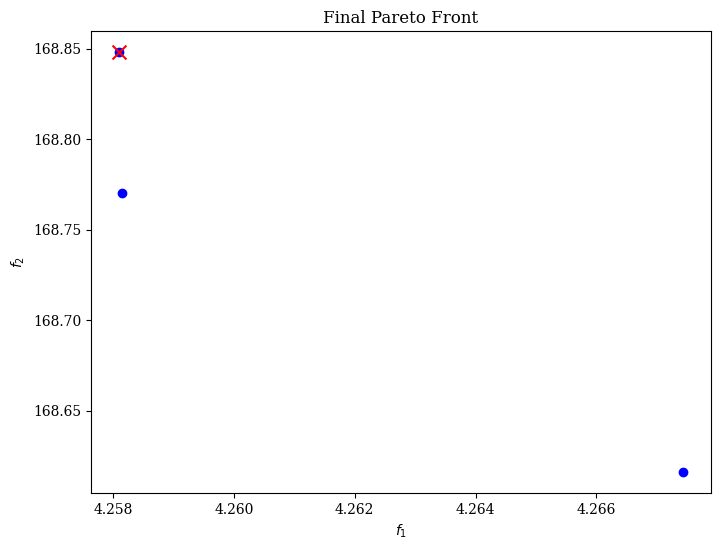

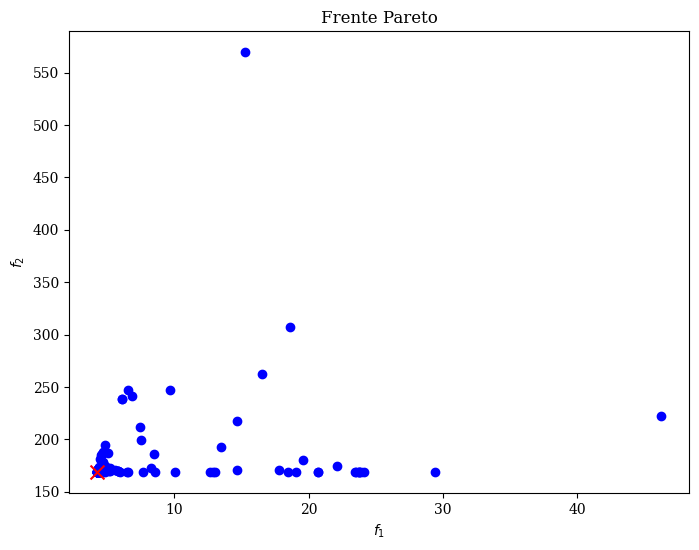

In [39]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.util.termination.default import SingleObjectiveDefaultTermination
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

#PARAMETROS
GEN = 30
POP = 10
MUT = 0.1
CROSSOVER = 0.8

# Definir las funciones de ind con parámetros y constantes originales
ind_original = [
    lambda Re, S: S**(-0.6) + 5.0*Re**(-0.23),
    lambda Re, S: 20.0*(S*Re**0.2)**(-1.1),
    lambda Re, Pr, S: 0.5*S**(-0.2)*Re**0.63*Pr
]

ind = [Ind1([-0.6, 5.0, -0.23]), Ind2([20.0, 0.2, -1.1]), Ind3([0.5, -0.2, 0.63])]

# Extraer los valores originales de las constantes
initial_params = []
for func in ind_original:
    constants = func.__code__.co_consts
    initial_params.extend([c for c in constants if isinstance(c, (int, float))])

# Función que devuelve los resultados de df_mf para un conjunto dado de parámetros
def get_df_mf(params, n_celdas=102):
    global ind
    # Desempaquetar parámetros
    params_ind_1 = params[:3]
    params_ind_2 = params[3:6]
    params_ind_3 = params[6:]

    # Actualizar las constantes de las funciones ind
    ind[0].constants = params_ind_1
    ind[1].constants = params_ind_2
    ind[2].constants = params_ind_3

    # Llamar a tu función original para obtener df_mf
    _, df_mf = get_ansys_mf(n_celdas, df_ansys)

    return df_mf, ind

# Función objetivo para la optimización
# Función objetivo para la optimización con 2 objetivos
def objective(params, n_celdas=74):
    df_mf, ind = get_df_mf(params, n_celdas)
    errors = get_MAPE_dict(df_ansys, df_mf)
    
    # Definir los objetivos (minimizar el error de TF + TC y el error de V + P)
    obj1 = errors['TF'] + errors['TC']
    obj2 = errors['V'] + errors['P']
    
    return [obj1, obj2]


class CustomProblem(ElementwiseProblem):
    def __init__(self, n_var, xl, xu, ind):
        super().__init__(n_var=n_var, n_obj=2, n_constr=0, xl=xl, xu=xu)
        self.ind = ind  # Añadir ind como atributo de la clase

    def _evaluate(self, x, out, *args, **kwargs):
        # Desempaquetar parámetros
        params_ind_1 = x[:3]
        params_ind_2 = x[3:6]
        params_ind_3 = x[6:]

        # Actualizar las constantes de las funciones ind
        self.ind[0].constants = params_ind_1
        self.ind[1].constants = params_ind_2
        self.ind[2].constants = params_ind_3
        # Llamar a tu función original para obtener df_mf
        _, df_mf = get_ansys_mf(n_celdas, df_ansys)

        # Tu lógica de evaluación aquí
        errors = get_MAPE_dict(df_ansys, df_mf)
        
        # Definir los objetivos (minimizar el error de TF + TC y el error de V + P)
        obj1 = errors['TF'] + errors['TC']
        obj2 = errors['V'] + errors['P']
        
        out["F"] = [obj1, obj2]

        
class MyCallback:
    def __init__(self):
        self.rows_list = []
        self.fronts = []
        self.cumulative_front = []

    def __call__(self, algorithm):
        # Obtener el frente de Pareto actual
        front = algorithm.pop.get("F")

        # Guardar el frente de Pareto actual
        self.fronts.append(front)

        # Obtener todas las soluciones no dominadas encontradas hasta ahora
        cumulative_front = np.concatenate(self.fronts, axis=0)

        # Utilizar la función unique de NumPy para obtener índices únicos
        unique_indices = np.unique(cumulative_front, axis=0, return_index=True)[1]
        self.cumulative_front = cumulative_front[unique_indices]


        # Obtener el mejor individuo en la población actual
        best_ind = front.min(axis=0)

        # Obtener las constantes del mejor individuo
        best_constants = algorithm.pop.get("X")[0]

        # Obtener la generación actual
        generation = algorithm.n_gen

        # Crear un diccionario con los datos de la generación actual
        row_dict = {'Generation': generation}
        for i, value in enumerate(best_ind):
            row_dict[f'Objective_{i+1}'] = value
        for i, constant in enumerate(best_constants):
            row_dict[f'Constant_{i+1}'] = constant

        # Añadir la fila a la lista
        self.rows_list.append(row_dict)

        # Imprimir el progreso
        print(f"Generation {generation}: Best Objectives = {best_ind}")

        # Visualizar el frente de Pareto en cada generación
        scatter = Scatter(title=f'Generation {generation}')
        scatter.add(front, color="red")
        scatter.show()



# Crear una instancia de la devolución de llamada
callback = MyCallback()
n_celdas = 74

# Inicializar la población con los valores iniciales
initial_population = np.array([initial_params])

# Configurar el algoritmo evolutivo (NSGA-II) con la devolución de llamada
algorithm = NSGA2(
    pop_size=POP,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=CROSSOVER, eta=3.0),
    mutation=get_mutation("real_pm", prob=MUT ,eta=3.0),
    eliminate_duplicates=True,
    pop_initializer=initial_population  # Establecer la población inicial aquí
)

# Definir límites para cada parámetro (ajusta según tus necesidades)
lower_bound = np.array([c - 0.1 for c in initial_params])
upper_bound = np.array([c + 0.1 for c in initial_params])

# Definir problema de optimización
problem = CustomProblem(n_var=len(initial_params), xl=lower_bound, xu=upper_bound, ind=ind)

# Ejecutar la optimización con la devolución de llamada
result = minimize(problem, algorithm, ('n_gen', GEN), callback=callback, seed=1, verbose=True)

# Obtener los mejores parámetros después de la optimización
best_params_pymoo = result.X[0]

# Obtener df_mf para los mejores parámetros
best_df_mf_pymoo, _ = get_df_mf(best_params_pymoo, n_celdas)

# Obtener los errores finales
final_errors_pymoo = get_MAPE_dict(df_ansys, best_df_mf_pymoo)

# Imprimir los resultados
print("Mejores parámetros (pymoo):", best_params_pymoo)
print("Errores finales (pymoo):", final_errors_pymoo)

# Visualizar el frente de Pareto final
scatter_final = Scatter(title='Final Pareto Front')
scatter_final.add(result.F, color="blue")  # Agrega el frente de Pareto en azul

# Obtener las coordenadas del punto correspondiente a los mejores parámetros
best_point_final = result.F[0]
# Agrega el punto correspondiente a los mejores parámetros en rojo
scatter_final.add(np.array([best_point_final]), color="red", marker="x", s=100)

# Visualizar el frente de Pareto acumulado
scatter_cumulative = Scatter(title='Frente Pareto')
scatter_cumulative.add(callback.cumulative_front, color="blue")  # Agrega el frente acumulado en verde

# Obtener las coordenadas del punto correspondiente a los mejores parámetros en el frente acumulado
best_point_cumulative = callback.cumulative_front[0]
# Agrega el punto correspondiente a los mejores parámetros en rojo en el frente acumulado
scatter_cumulative.add(np.array([best_point_cumulative]), color="red", marker="x", s=100)

scatter_final.show()
scatter_cumulative.show()

# Convertir la lista de filas en un DataFrame
columns = ['Generation'] + [f'Objective_{i+1}' for i in range(2)] + [f'Constant_{i+1}' for i in range(9)]
result_df = pd.DataFrame(callback.rows_list, columns=columns)

# Guardar el DataFrame en un archivo CSV
csv_filename = "optimization_results_pareto_xd.csv"
result_df.to_csv(csv_filename, index=False)

print(f"Resultados guardados en {csv_filename}")